# CNN Deforestation Detection Pipeline
**Patch-based 2D CNN with Spatial Context**

Du an: Giam sat Bien dong Rung tinh Ca Mau | SV: Ninh Hai Dang (21021411)

## Pipeline Overview
1. Setup & Libraries -> 2. Load Data -> 3. Feature Extraction -> 4. Spatial Split -> 5. Extract Patches -> 6. Train CNN -> 7. Evaluate -> 8. Predict -> 9. Visualize -> 10. Summary

## 1️⃣ Setup & Import Libraries

In [1]:
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Geospatial
import rasterio
from rasterio.plot import show

# Sklearn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report
)

# Check PyTorch and CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("Using CPU")
    device = 'cpu'

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

print("\n✓ Libraries imported successfully!")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1060 6GB

✓ Libraries imported successfully!


### Configuration

In [2]:
# Configuration
CONFIG = {
    # Model
    'patch_size': 3,
    'n_features': 27,
    'n_classes': 4,  # ✅ Updated to 4 classes
    'normalize_method': 'standardize',  # 'standardize' or 'minmax'
    'dropout_rate': 0.7,  # Increased to prevent overfitting
    
    # Training
    'epochs': 200,  # Increased for more training
    'batch_size': 64,  # Increased from 32
    'learning_rate': 0.001,
    'weight_decay': 1e-3,  # Increased to prevent overfitting
    'early_stopping_patience': 15,  # Reduced from 50 for faster stopping
    

    # Learning Rate Scheduler (for long training)
    'use_lr_scheduler': True,
    'lr_scheduler_type': 'ReduceLROnPlateau',
    'lr_scheduler_patience': 10,  # Reduced from 15
    'lr_scheduler_factor': 0.5,
    'lr_min': 1e-6,
    
    # Data split (Random Split)
    'train_size': 0.70,
    'val_size': 0.15,
    'test_size': 0.15,
    
    # Device
    'device': device,
    
    # Prediction
    'pred_batch_size': 8000,
    'pred_stride': 1,
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key:25s}: {value}")


Configuration:
  patch_size               : 3
  n_features               : 27
  n_classes                : 4
  normalize_method         : standardize
  dropout_rate             : 0.7
  epochs                   : 200
  batch_size               : 64
  learning_rate            : 0.001
  weight_decay             : 0.001
  early_stopping_patience  : 15
  use_lr_scheduler         : True
  lr_scheduler_type        : ReduceLROnPlateau
  lr_scheduler_patience    : 10
  lr_scheduler_factor      : 0.5
  lr_min                   : 1e-06
  train_size               : 0.7
  val_size                 : 0.15
  test_size                : 0.15
  device                   : cuda
  pred_batch_size          : 8000
  pred_stride              : 1


## 2️⃣ Load Data

In [3]:
from core.data_loader import DataLoader

print("Loading data...")
loader = DataLoader()

# Load all data
s2_before, s2_after = loader.load_sentinel2()
s1_before, s1_after = loader.load_sentinel1()
ground_truth = loader.load_ground_truth()
boundary = loader.load_boundary()

# Store metadata
metadata = loader.metadata

print("\n✓ Data loaded successfully!")
print(f"\nGround truth points: {len(ground_truth)}")
print(f"Class distribution:")
print(ground_truth['label'].value_counts())


2025-11-20 13:16:48 - core.data_loader - INFO - 
2025-11-20 13:16:48 - core.data_loader - INFO - LOADING SENTINEL-2 DATA (OPTICAL)
2025-11-20 13:16:48 - core.data_loader - INFO - ======================================================================
2025-11-20 13:16:48 - core.data_loader - INFO - Loading Sentinel-2 Before (2024-01-30): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-2\S2_2024_01_30.tif


Loading data...


2025-11-20 13:17:11 - core.data_loader - INFO -   [OK] Shape: (7, 10917, 12547)
2025-11-20 13:17:11 - core.data_loader - INFO -   [OK] Bands: 7
2025-11-20 13:17:11 - core.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-20 13:17:11 - core.data_loader - INFO -   [OK] NoData: 0.0
2025-11-20 13:17:22 - core.data_loader - INFO - Loading Sentinel-2 After (2025-02-28): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-2\S2_2025_02_28.tif
2025-11-20 13:17:47 - core.data_loader - INFO -   [OK] Shape: (7, 10917, 12547)
2025-11-20 13:17:47 - core.data_loader - INFO -   [OK] Bands: 7
2025-11-20 13:17:47 - core.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-20 13:17:47 - core.data_loader - INFO -   [OK] NoData: 0.0
2025-11-20 13:17:58 - core.data_loader - INFO - 
[OK] Sentinel-2 data loaded successfully
2025-11-20 13:17:58 - core.data_loader - INFO -   - Expected bands: ['B4', 'B8', 'B11', 'B12', 'NDVI', 'NBR', 'NDMI']
2025-11-20 13:17:58 - core.data_loader - INFO - 
2025-11-


✓ Data loaded successfully!

Ground truth points: 2630
Class distribution:
label
2    664
3    660
0    656
1    650
Name: count, dtype: int64


## 3️⃣ Feature Extraction

In [4]:
from core.feature_extraction import FeatureExtraction

print("Extracting features...")
extractor = FeatureExtraction()

feature_stack, valid_mask = extractor.extract_features(
    s2_before, s2_after,
    s1_before, s1_after
)

print(f"\n✓ Feature extraction completed!")
print(f"Feature stack shape: {feature_stack.shape}")
print(f"Valid pixels: {valid_mask.sum():,} / {valid_mask.size:,} ({valid_mask.sum()/valid_mask.size*100:.2f}%)")


2025-11-20 13:18:17 - core.feature_extraction - INFO - 
2025-11-20 13:18:17 - core.feature_extraction - INFO - STEP 3: FEATURE EXTRACTION
2025-11-20 13:18:17 - core.feature_extraction - INFO - ======================================================================
2025-11-20 13:18:17 - core.feature_extraction - INFO - 
Input dimensions: 10917 x 12547
2025-11-20 13:18:17 - core.feature_extraction - INFO - 
Creating valid pixel mask (relaxed for cloud coverage)...


Extracting features...


2025-11-20 13:18:24 - core.feature_extraction - INFO -   ✓ Total valid pixels: 16,246,925 / 136,975,599 (11.86%)
2025-11-20 13:18:24 - core.feature_extraction - INFO -   ✓ Pixels with S2 data: 15,571,487 (11.37%)
2025-11-20 13:18:24 - core.feature_extraction - INFO -   ✓ S1-only pixels (cloudy): 675,438 (0.49%)
2025-11-20 13:18:24 - core.feature_extraction - INFO - 
Extracting Sentinel-2 features...
2025-11-20 13:18:26 - core.feature_extraction - INFO -   - Imputing S2 values for cloudy pixels using median...
2025-11-20 13:18:33 - core.feature_extraction - INFO -   - Adding S2 Before bands (7 features)
2025-11-20 13:18:33 - core.feature_extraction - INFO -   - Adding S2 After bands (7 features)
2025-11-20 13:18:33 - core.feature_extraction - INFO -   - Calculating S2 Delta (7 features)
2025-11-20 13:18:35 - core.feature_extraction - INFO -   ✓ Total S2 features: 21
2025-11-20 13:18:35 - core.feature_extraction - INFO - 
Extracting Sentinel-1 features...
2025-11-20 13:18:35 - core.featu


✓ Feature extraction completed!
Feature stack shape: (27, 10917, 12547)
Valid pixels: 16,246,925 / 136,975,599 (11.86%)


### Feature Distribution Analysis - Pairplot

Visualize relationships between features and class distributions using seaborn pairplot.

print("Creating feature pairplot for exploratory data analysis...")
print(f"Using ALL {len(ground_truth)} ground truth samples and ALL {CONFIG['n_features']} features\n")

# Extract feature values at ALL ground truth points
from rasterio.transform import rowcol
from config import FEATURE_NAMES

all_features = []
all_labels = []

print("Extracting features at all ground truth locations...")
for idx, row in ground_truth.iterrows():
    # Convert coordinates to pixel indices
    py, px = rowcol(metadata['s2_before']['transform'], row['x'], row['y'])
    
    # Check if within bounds and valid
    if (0 <= py < feature_stack.shape[1] and 
        0 <= px < feature_stack.shape[2] and 
        valid_mask[py, px]):
        
        # Extract ALL features at this point
        features = feature_stack[:, py, px]
        all_features.append(features)
        all_labels.append(row['label'])

# Convert to arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

print(f"✓ Extracted {len(all_features)} valid samples\n")

# Define ALL feature names (27 features total)
feature_names = FEATURE_NAMES

# Create DataFrame with ALL features
df_pairplot = pd.DataFrame(all_features, columns=feature_names)
df_pairplot['Class'] = all_labels
df_pairplot['Class'] = df_pairplot['Class'].map({
    0: 'Forest Stable',
    1: 'Deforestation', 
    2: 'Non-forest',
    3: 'Reforestation'
})

# Create pairplot with ALL features
print(f"Creating comprehensive pairplot with {len(df_pairplot)} samples and {len(feature_names)} features...")
print("⚠️  WARNING: This will create a 27x27 grid (729 subplots) and may take 10-15 minutes!")
print("Consider using a subset if this is too slow.\n")

fig = sns.pairplot(
    df_pairplot,
    hue='Class',
    palette={
        'Forest Stable': '#2d5f2e',
        'Deforestation': '#d62728',
        'Non-forest': '#8c6d31',
        'Reforestation': '#90ee90'
    },
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 20},  # Smaller points for many samples
    diag_kws={'alpha': 0.7, 'linewidth': 1.5},
    corner=False  # Show full matrix
)

fig.fig.suptitle('Complete Feature Relationships by Land Cover Class (All 27 Features)', 
                 y=1.0, fontsize=18, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/plots/feature_pairplot_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Complete pairplot saved to: ../results/plots/feature_pairplot_complete.png")
print(f"\nPairplot Summary:")
print(f"  Samples visualized: {len(df_pairplot)} (ALL ground truth points)")
print(f"  Features shown: {len(feature_names)} (ALL features)")
print(f"  Classes: 4 (Forest Stable, Deforestation, Non-forest, Reforestation)")
print(f"  Grid size: {len(feature_names)}x{len(feature_names)} = {len(feature_names)**2} subplots")
print(f"\n💡 The complete pairplot shows:")
print(f"  - Diagonal: Distribution of each feature by class (KDE)")
print(f"  - Off-diagonal: Scatter plots showing all feature relationships")
print(f"  - Color: Different classes for pattern identification")
print(f"  - All 27 features: S2 bands, indices, S1 backscatter, SAR indices, textures")

## 4️⃣ Split Fixed Test Set (20%)

**Quy trình đúng:**
1. Tách 20% test cố định - KHÔNG BAO GIỜ động đến
2. 5-fold CV trên 80% còn lại - để chọn hyperparameters
3. Train mô hình cuối trên toàn bộ 80%
4. Đánh giá cuối trên 20% test cố định

**Phương pháp chia:** Random split thông thường (stratified)

In [6]:
from models.cnn.random_split import RandomKFoldWithFixedTest

print("="*70)
print("STEP 1: SPLIT OFF FIXED TEST SET (20%)")
print("="*70)

# Initialize splitter with RANDOM SPLIT (stratified)
cv_splitter = RandomKFoldWithFixedTest(
    test_size=0.2,  # 20% fixed test set
    n_splits=5,      # 5-fold CV on remaining 80%
    random_state=RANDOM_STATE,
    shuffle=True
)

# Split off fixed test set using random split (stratified)
trainval_indices, test_indices_fixed, split_metadata = cv_splitter.split_fixed_test(
    ground_truth,
    stratify_by_class=True
)

# Get the train+val subset for CV
ground_truth_trainval = ground_truth.iloc[trainval_indices].reset_index(drop=True)
ground_truth_test_fixed = ground_truth.iloc[test_indices_fixed].reset_index(drop=True)

print(f"\n✅ FIXED TEST SET CREATED:")
print(f"   Total samples: {len(ground_truth)}")
print(f"   Train+Val (for CV): {len(trainval_indices)} ({len(trainval_indices)/len(ground_truth)*100:.1f}%)")
print(f"   Test (FIXED, held-out): {len(test_indices_fixed)} ({len(test_indices_fixed)/len(ground_truth)*100:.1f}%)")

print(f"\n✅ Fixed test set class distribution:")
for label in sorted(ground_truth_test_fixed['label'].unique()):
    count = (ground_truth_test_fixed['label'] == label).sum()
    print(f"   Class {label}: {count} ({count/len(ground_truth_test_fixed)*100:.1f}%)")

2025-11-20 13:31:47 - models.cnn.random_split - INFO - 
2025-11-20 13:31:47 - models.cnn.random_split - INFO - STEP 1: SPLIT OFF FIXED TEST SET
2025-11-20 13:31:47 - models.cnn.random_split - INFO - ======================================================================
2025-11-20 13:31:47 - models.cnn.random_split - INFO - Test size: 20.0%
2025-11-20 13:31:47 - models.cnn.random_split - INFO - Using RANDOM SPLIT (stratified by class)
2025-11-20 13:31:47 - models.cnn.random_split - INFO - 
✅ Fixed test set created:
2025-11-20 13:31:47 - models.cnn.random_split - INFO -    Train+Val: 2104 samples (80.0%)
2025-11-20 13:31:47 - models.cnn.random_split - INFO -    Test (FIXED): 526 samples (20.0%)
2025-11-20 13:31:47 - models.cnn.random_split - INFO - 
   Test set class distribution:
2025-11-20 13:31:47 - models.cnn.random_split - INFO -      Class 0: 131 (24.9%)
2025-11-20 13:31:47 - models.cnn.random_split - INFO -      Class 1: 130 (24.7%)
2025-11-20 13:31:47 - models.cnn.random_split - 

STEP 1: SPLIT OFF FIXED TEST SET (20%)

✅ FIXED TEST SET CREATED:
   Total samples: 2630
   Train+Val (for CV): 2104 (80.0%)
   Test (FIXED, held-out): 526 (20.0%)

✅ Fixed test set class distribution:
   Class 0: 131 (24.9%)
   Class 1: 130 (24.7%)
   Class 2: 133 (25.3%)
   Class 3: 132 (25.1%)


In [7]:
# Reload modules to get latest changes
import importlib
import sys

# Remove old modules from cache
modules_to_reload = [
    'models.cnn.spatial_split',
    'models.cnn.random_split',
    'core.data_loader', 
    'core.feature_extraction'
]
for module in modules_to_reload:
    if module in sys.modules:
        del sys.modules[module]

print("✓ Modules reloaded!")

✓ Modules reloaded!


## 5️⃣ Extract Patches for Fixed Test Set

Trích xuất patches tại fixed test set locations

In [8]:
from models.cnn.patch_extractor import PatchExtractor

print("Extracting patches for FIXED TEST SET...")
patch_extractor_test = PatchExtractor(patch_size=CONFIG['patch_size'])

X_test_fixed, y_test_fixed, _ = patch_extractor_test.extract_patches_at_points(
    feature_stack,
    ground_truth_test_fixed,
    metadata['s2_before']['transform'],
    valid_mask
)

# Normalize and SAVE normalization stats (will use for train+val later)
X_test_fixed, normalization_stats = patch_extractor_test.normalize_patches(method=CONFIG['normalize_method'])

print(f"\n✅ Fixed test patches extracted!")
print(f"  Patches shape: {X_test_fixed.shape}")
print(f"  Labels shape: {y_test_fixed.shape}")
print(f"  Normalization stats saved!")

print(f"\n✅ Fixed test set class distribution:")
for label in sorted(np.unique(y_test_fixed)):
    count = (y_test_fixed == label).sum()
    print(f"  Class {label}: {count} ({count/len(y_test_fixed)*100:.1f}%)")

2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - 
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - EXTRACTING PATCHES AT GROUND TRUTH POINTS
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Feature stack shape: (27, 10917, 12547)
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Patch size: 3x3
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Ground truth points: 526


Extracting patches for FIXED TEST SET...


2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - 
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - PATCH EXTRACTION SUMMARY
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Total ground truth points: 526
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Valid patches extracted: 526
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Skipped (edge): 0
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Skipped (NoData): 0
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Success rate: 100.00%
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - 
Patch shape: (526, 3, 3, 27)
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Labels shape: (526,)
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - 
Class distribution:
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO -   Class 0: 131 


✅ Fixed test patches extracted!
  Patches shape: (526, 3, 3, 27)
  Labels shape: (526,)
  Normalization stats saved!

✅ Fixed test set class distribution:
  Class 0: 131 (24.9%)
  Class 1: 130 (24.7%)
  Class 2: 133 (25.3%)
  Class 3: 132 (25.1%)


## 6️⃣ 5-Fold Cross-Validation on Train+Val Data

**Mục đích:** Tìm hyperparameters/architecture tốt nhất

- Train 5 models khác nhau (mỗi fold 1 model)
- Đánh giá trên validation của mỗi fold
- Lấy **trung bình metrics** để đánh giá
- **KHÔNG LẤY** bất kỳ model nào trong 5 models này làm model cuối

In [9]:
from models.cnn.architecture import create_model
from models.cnn.trainer import CNNTrainer

print("="*70)
print("STEP 2: 5-FOLD CROSS-VALIDATION")
print("="*70)

cv_start_time = time.time()
fold_results = []

# Iterate through 5 folds
for fold_idx, train_indices_cv, val_indices_cv in cv_splitter.cross_validate(
    ground_truth_trainval,
    stratify_by_class=True
):
    print(f"\n{'='*70}")
    print(f"FOLD {fold_idx + 1}/5")
    print(f"{'='*70}")
    
    # Get ground truth for this fold
    gt_train_cv = ground_truth_trainval.iloc[train_indices_cv].reset_index(drop=True)
    gt_val_cv = ground_truth_trainval.iloc[val_indices_cv].reset_index(drop=True)
    
    # Extract patches for this fold
    print(f"\nExtracting patches for Fold {fold_idx + 1}...")
    patch_extractor_train = PatchExtractor(patch_size=CONFIG['patch_size'])
    X_train_cv, y_train_cv, _ = patch_extractor_train.extract_patches_at_points(
        feature_stack, gt_train_cv,
        metadata['s2_before']['transform'], valid_mask
    )
    X_train_cv, _ = patch_extractor_train.normalize_patches(method=CONFIG['normalize_method'])
    
    patch_extractor_val = PatchExtractor(patch_size=CONFIG['patch_size'])
    X_val_cv, y_val_cv, _ = patch_extractor_val.extract_patches_at_points(
        feature_stack, gt_val_cv,
        metadata['s2_before']['transform'], valid_mask
    )
    X_val_cv, _ = patch_extractor_val.normalize_patches(method=CONFIG['normalize_method'])
    
    print(f"  Train: {len(X_train_cv)} patches, Val: {len(X_val_cv)} patches")
    
    # Calculate class weights
    unique, counts = np.unique(y_train_cv, return_counts=True)
    class_weights = [len(y_train_cv) / (len(unique) * c) for c in counts]
    
    # Create and train model
    print(f"\nTraining Fold {fold_idx + 1}...")
    model_cv = create_model(
        model_type='standard',
        patch_size=CONFIG['patch_size'],
        n_features=CONFIG['n_features'],
        n_classes=CONFIG['n_classes'],
        dropout_rate=CONFIG['dropout_rate']
    )
    
    trainer_cv = CNNTrainer(
        model=model_cv,
        device=CONFIG['device'],
        learning_rate=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        class_weights=class_weights,
        use_lr_scheduler=CONFIG['use_lr_scheduler'],
        lr_scheduler_patience=CONFIG['lr_scheduler_patience'],
        lr_scheduler_factor=CONFIG['lr_scheduler_factor'],
        lr_min=CONFIG['lr_min']
    )
    
    history_cv = trainer_cv.fit(
        X_train_cv, y_train_cv,
        X_val_cv, y_val_cv,
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size'],
        early_stopping_patience=CONFIG['early_stopping_patience']
    )
    
    # Evaluate on validation set
    val_metrics_cv = trainer_cv.evaluate(X_val_cv, y_val_cv, batch_size=CONFIG['batch_size'])
    
    # Compute confusion matrix for this fold
    cm_fold = confusion_matrix(val_metrics_cv['labels'], val_metrics_cv['predictions'])
    
    # Save fold results (including confusion matrix)
    fold_results.append({
        'fold': fold_idx + 1,
        'train_acc': history_cv['train_acc'][-1] / 100.0,
        'train_loss': history_cv['train_loss'][-1],
        'val_acc': val_metrics_cv['accuracy'],
        'val_precision': val_metrics_cv['precision'],
        'val_recall': val_metrics_cv['recall'],
        'val_f1': val_metrics_cv['f1_score'],
        'val_roc_auc': val_metrics_cv['roc_auc'],
        'confusion_matrix': cm_fold.tolist()  # ← Save confusion matrix
    })
    
    print(f"\nFold {fold_idx + 1} Results:")
    print(f"  Val Accuracy: {val_metrics_cv['accuracy']:.4f}")
    print(f"  Val F1-Score: {val_metrics_cv['f1_score']:.4f}")

cv_total_time = time.time() - cv_start_time

# Print CV summary
print("\n" + "="*70)
print("5-FOLD CV SUMMARY")
print("="*70)
val_accs = [r['val_acc'] for r in fold_results]
val_f1s = [r['val_f1'] for r in fold_results]
print(f"\nValidation Accuracy: {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")
print(f"Validation F1-Score: {np.mean(val_f1s):.4f} ± {np.std(val_f1s):.4f}")
print(f"\nTotal CV time: {cv_total_time/60:.2f} minutes")
print("\n✅ Cross-validation completed!")
print("="*70)

2025-11-20 13:31:47 - models.cnn.random_split - INFO - 


STEP 2: 5-FOLD CROSS-VALIDATION


2025-11-20 13:31:47 - models.cnn.random_split - INFO - STEP 2: K-FOLD CV ON TRAIN+VAL DATA
2025-11-20 13:31:47 - models.cnn.random_split - INFO - ======================================================================
2025-11-20 13:31:47 - models.cnn.random_split - INFO - Number of folds: 5
2025-11-20 13:31:47 - models.cnn.random_split - INFO - Data size: 2104 samples
2025-11-20 13:31:47 - models.cnn.random_split - INFO - Using RANDOM K-FOLD (stratified by class)
2025-11-20 13:31:47 - models.cnn.random_split - INFO - 
Fold 1/5:
2025-11-20 13:31:47 - models.cnn.random_split - INFO -   Train: 1683 samples (80.0%)
2025-11-20 13:31:47 - models.cnn.random_split - INFO -   Val: 421 samples (20.0%)
2025-11-20 13:31:47 - models.cnn.random_split - INFO -   Train classes: {0: np.int64(420), 1: np.int64(416), 2: np.int64(425), 3: np.int64(422)}
2025-11-20 13:31:47 - models.cnn.random_split - INFO -   Val classes: {0: np.int64(105), 1: np.int64(104), 2: np.int64(106), 3: np.int64(106)}
2025-11-20 1


FOLD 1/5

Extracting patches for Fold 1...


2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - 
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - PATCH EXTRACTION SUMMARY
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Total ground truth points: 1683
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Valid patches extracted: 1682
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Skipped (edge): 0
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Skipped (NoData): 1
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Success rate: 99.94%
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - 
Patch shape: (1682, 3, 3, 27)
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - Labels shape: (1682,)
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO - 
Class distribution:
2025-11-20 13:31:47 - models.cnn.patch_extractor - INFO -   Class 0: 4

  Train: 1682 patches, Val: 421 patches

Training Fold 1...


2025-11-20 13:31:50 - models.cnn.trainer - INFO - Learning Rate Scheduler enabled (patience=10, factor=0.5, min_lr=1e-06)
2025-11-20 13:31:50 - models.cnn.trainer - INFO - Trainer initialized on device: cuda
2025-11-20 13:31:50 - models.cnn.trainer - INFO - Model parameters: 36,676
2025-11-20 13:31:50 - models.cnn.trainer - INFO - 
2025-11-20 13:31:50 - models.cnn.trainer - INFO - STARTING CNN TRAINING
2025-11-20 13:31:50 - models.cnn.trainer - INFO - ======================================================================
2025-11-20 13:31:50 - models.cnn.trainer - INFO - Training samples: 1682
2025-11-20 13:31:50 - models.cnn.trainer - INFO - Validation samples: 421
2025-11-20 13:31:50 - models.cnn.trainer - INFO - Epochs: 200
2025-11-20 13:31:50 - models.cnn.trainer - INFO - Batch size: 64
2025-11-20 13:31:50 - models.cnn.trainer - INFO - Learning rate: 0.001
2025-11-20 13:31:50 - models.cnn.trainer - INFO - Device: cuda
2025-11-20 13:31:50 - models.cnn.trainer - INFO - ===============


Fold 1 Results:
  Val Accuracy: 0.9929
  Val F1-Score: 0.9929

FOLD 2/5

Extracting patches for Fold 2...


2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - 
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - PATCH EXTRACTION SUMMARY
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - Total ground truth points: 1683
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - Valid patches extracted: 1682
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - Skipped (edge): 0
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - Skipped (NoData): 1
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - Success rate: 99.94%
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - 
Patch shape: (1682, 3, 3, 27)
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - Labels shape: (1682,)
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO - 
Class distribution:
2025-11-20 13:32:17 - models.cnn.patch_extractor - INFO -   Class 0: 4

  Train: 1682 patches, Val: 421 patches

Training Fold 2...


2025-11-20 13:32:17 - models.cnn.trainer - INFO - Epoch   1/200 | Train Loss: 1.1874 | Train Acc:  53.63% | Val Loss: 0.3150 | Val Acc:  97.86% | LR: 0.001000
2025-11-20 13:32:17 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.3150, Val Acc: 97.86%
2025-11-20 13:32:17 - models.cnn.trainer - INFO - Epoch   2/200 | Train Loss: 0.6047 | Train Acc:  77.23% | Val Loss: 0.1664 | Val Acc:  98.10% | LR: 0.001000
2025-11-20 13:32:17 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.1664, Val Acc: 98.10%
2025-11-20 13:32:17 - models.cnn.trainer - INFO - Epoch   3/200 | Train Loss: 0.4386 | Train Acc:  84.42% | Val Loss: 0.1129 | Val Acc:  98.34% | LR: 0.001000
2025-11-20 13:32:17 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.1129, Val Acc: 98.34%
2025-11-20 13:32:18 - models.cnn.trainer - INFO - Epoch   4/200 | Train Loss: 0.3397 | Train Acc:  89.89% | Val Loss: 0.0812 | Val Acc:  98.34% | LR: 0.001000
2025-11-20 13:32:18 - models.cnn.trainer - INFO -   


Fold 2 Results:
  Val Accuracy: 0.9929
  Val F1-Score: 0.9929

FOLD 3/5

Extracting patches for Fold 3...


2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - 
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - PATCH EXTRACTION SUMMARY
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - Total ground truth points: 1683
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - Valid patches extracted: 1682
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - Skipped (edge): 0
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - Skipped (NoData): 1
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - Success rate: 99.94%
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - 
Patch shape: (1682, 3, 3, 27)
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - Labels shape: (1682,)
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO - 
Class distribution:
2025-11-20 13:32:35 - models.cnn.patch_extractor - INFO -   Class 0: 4

  Train: 1682 patches, Val: 421 patches

Training Fold 3...


2025-11-20 13:32:35 - models.cnn.trainer - INFO - Epoch   1/200 | Train Loss: 1.0417 | Train Acc:  59.63% | Val Loss: 0.2682 | Val Acc:  97.86% | LR: 0.001000
2025-11-20 13:32:35 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.2682, Val Acc: 97.86%
2025-11-20 13:32:35 - models.cnn.trainer - INFO - Epoch   2/200 | Train Loss: 0.5373 | Train Acc:  80.74% | Val Loss: 0.1351 | Val Acc:  97.86% | LR: 0.001000
2025-11-20 13:32:35 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.1351, Val Acc: 97.86%
2025-11-20 13:32:36 - models.cnn.trainer - INFO - Epoch   3/200 | Train Loss: 0.3908 | Train Acc:  87.34% | Val Loss: 0.0964 | Val Acc:  97.86% | LR: 0.001000
2025-11-20 13:32:36 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.0964, Val Acc: 97.86%
2025-11-20 13:32:36 - models.cnn.trainer - INFO - Epoch   4/200 | Train Loss: 0.3232 | Train Acc:  90.73% | Val Loss: 0.0786 | Val Acc:  98.10% | LR: 0.001000
2025-11-20 13:32:36 - models.cnn.trainer - INFO -   


Fold 3 Results:
  Val Accuracy: 0.9810
  Val F1-Score: 0.9810

FOLD 4/5

Extracting patches for Fold 4...


2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - 
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - PATCH EXTRACTION SUMMARY
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - Total ground truth points: 1683
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - Valid patches extracted: 1683
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - Skipped (edge): 0
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - Skipped (NoData): 0
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - Success rate: 100.00%
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - 
Patch shape: (1683, 3, 3, 27)
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - Labels shape: (1683,)
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO - 
Class distribution:
2025-11-20 13:32:41 - models.cnn.patch_extractor - INFO -   Class 0: 

  Train: 1683 patches, Val: 420 patches

Training Fold 4...


2025-11-20 13:32:42 - models.cnn.trainer - INFO - Epoch   1/200 | Train Loss: 1.1658 | Train Acc:  54.43% | Val Loss: 0.2799 | Val Acc:  97.62% | LR: 0.001000
2025-11-20 13:32:42 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.2799, Val Acc: 97.62%
2025-11-20 13:32:42 - models.cnn.trainer - INFO - Epoch   2/200 | Train Loss: 0.6175 | Train Acc:  76.53% | Val Loss: 0.1464 | Val Acc:  97.62% | LR: 0.001000
2025-11-20 13:32:42 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.1464, Val Acc: 97.62%
2025-11-20 13:32:42 - models.cnn.trainer - INFO - Epoch   3/200 | Train Loss: 0.4003 | Train Acc:  86.63% | Val Loss: 0.1100 | Val Acc:  97.86% | LR: 0.001000
2025-11-20 13:32:42 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.1100, Val Acc: 97.86%
2025-11-20 13:32:43 - models.cnn.trainer - INFO - Epoch   4/200 | Train Loss: 0.3196 | Train Acc:  90.67% | Val Loss: 0.0950 | Val Acc:  97.86% | LR: 0.001000
2025-11-20 13:32:43 - models.cnn.trainer - INFO -   


Fold 4 Results:
  Val Accuracy: 0.9857
  Val F1-Score: 0.9857

FOLD 5/5

Extracting patches for Fold 5...


2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - 
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - PATCH EXTRACTION SUMMARY
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - Total ground truth points: 1684
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - Valid patches extracted: 1683
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - Skipped (edge): 0
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - Skipped (NoData): 1
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - Success rate: 99.94%
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - 
Patch shape: (1683, 3, 3, 27)
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - Labels shape: (1683,)
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO - 
Class distribution:
2025-11-20 13:33:12 - models.cnn.patch_extractor - INFO -   Class 0: 4

  Train: 1683 patches, Val: 420 patches

Training Fold 5...


2025-11-20 13:33:13 - models.cnn.trainer - INFO - Epoch   1/200 | Train Loss: 1.1157 | Train Acc:  59.06% | Val Loss: 0.2116 | Val Acc:  97.38% | LR: 0.001000
2025-11-20 13:33:13 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.2116, Val Acc: 97.38%
2025-11-20 13:33:13 - models.cnn.trainer - INFO - Epoch   2/200 | Train Loss: 0.5329 | Train Acc:  80.45% | Val Loss: 0.1164 | Val Acc:  97.38% | LR: 0.001000
2025-11-20 13:33:13 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.1164, Val Acc: 97.38%
2025-11-20 13:33:13 - models.cnn.trainer - INFO - Epoch   3/200 | Train Loss: 0.3736 | Train Acc:  88.00% | Val Loss: 0.1050 | Val Acc:  97.38% | LR: 0.001000
2025-11-20 13:33:13 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.1050, Val Acc: 97.38%
2025-11-20 13:33:13 - models.cnn.trainer - INFO - Epoch   4/200 | Train Loss: 0.2885 | Train Acc:  91.86% | Val Loss: 0.0933 | Val Acc:  97.38% | LR: 0.001000
2025-11-20 13:33:13 - models.cnn.trainer - INFO -   


Fold 5 Results:
  Val Accuracy: 0.9929
  Val F1-Score: 0.9929

5-FOLD CV SUMMARY

Validation Accuracy: 0.9891 ± 0.0049
Validation F1-Score: 0.9891 ± 0.0049

Total CV time: 1.66 minutes

✅ Cross-validation completed!



5-FOLD CV CONFUSION MATRICES


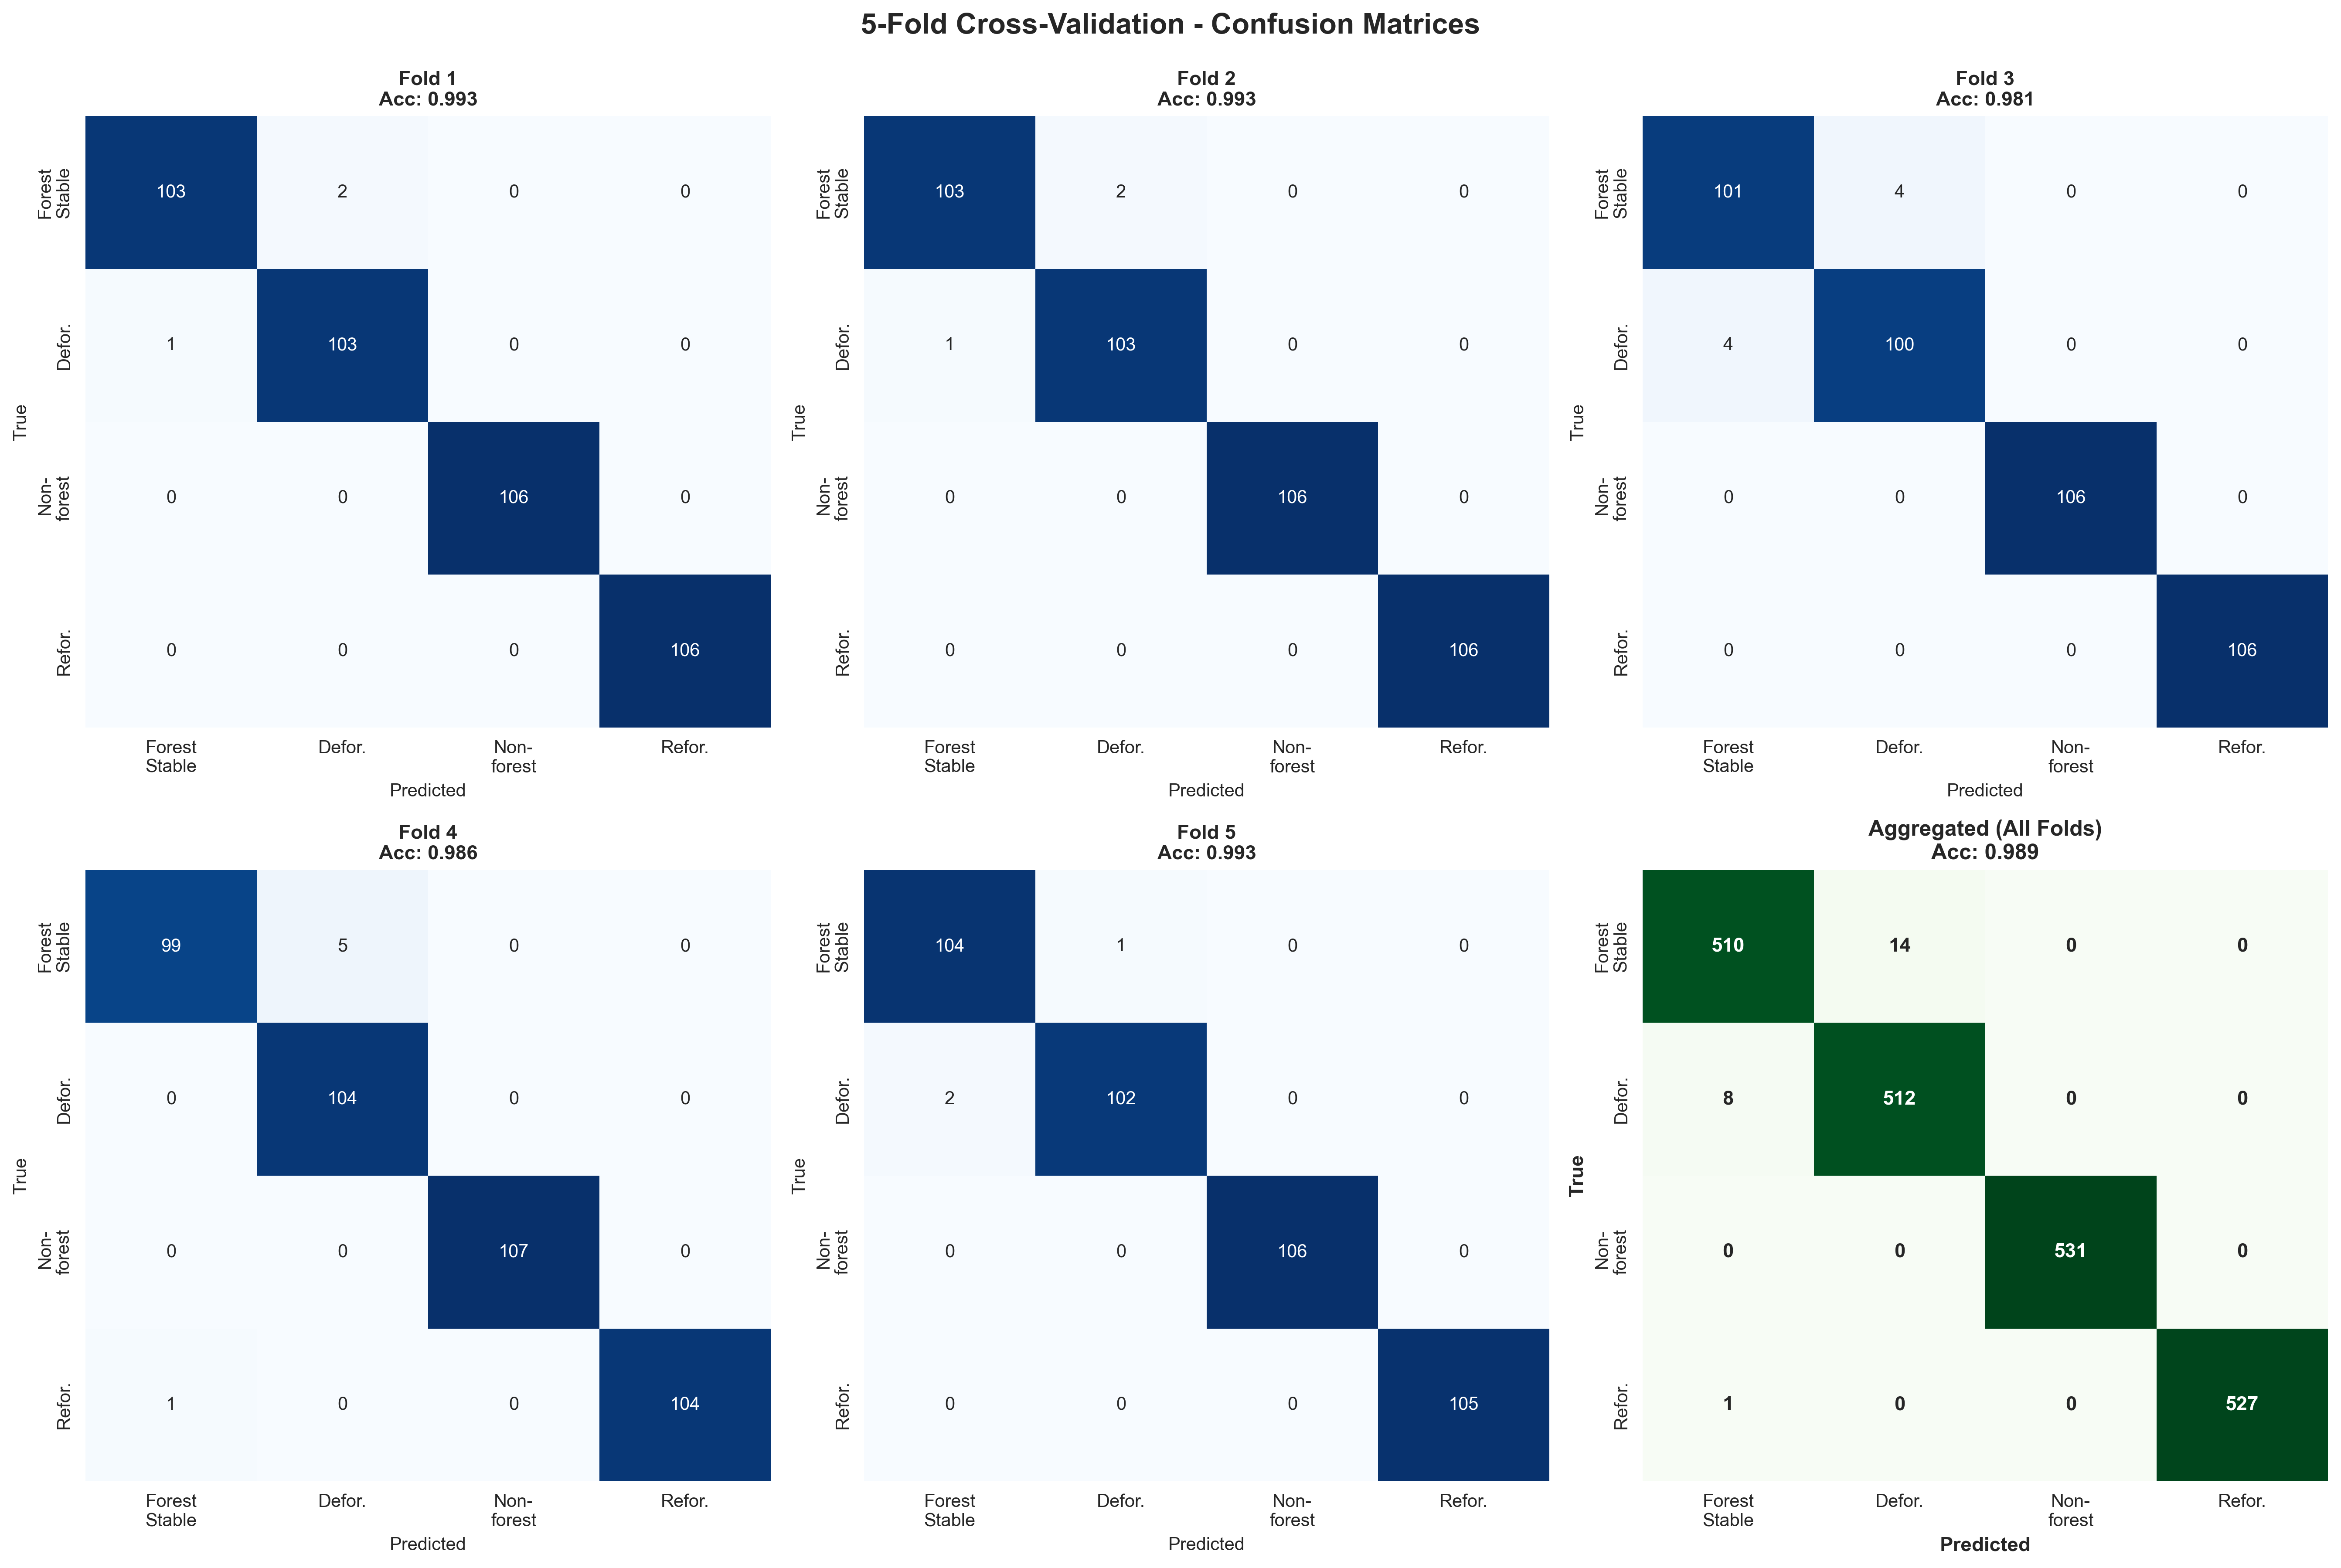


✓ Confusion matrices saved to: ../results/plots/cnn_cv_confusion_matrices.png

Aggregated Confusion Matrix:
[[510  14   0   0]
 [  8 512   0   0]
 [  0   0 531   0]
 [  1   0   0 527]]

Aggregated Accuracy: 0.9891 (98.91%)


In [10]:
# Plot confusion matrices for all 5 folds
print("\n" + "="*70)
print("5-FOLD CV CONFUSION MATRICES")
print("="*70)

# Class names for 4 classes
class_names = ['Forest\nStable', 'Defor.', 'Non-\nforest', 'Refor.']

# Create figure with 2 rows x 3 columns (5 folds + 1 aggregated)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Initialize aggregated confusion matrix
cm_aggregated = np.zeros((4, 4), dtype=int)

# Plot each fold's confusion matrix
for idx, result in enumerate(fold_results):
    ax = axes[idx]
    fold_num = result['fold']
    
    # Get confusion matrix for this fold (stored during CV)
    if 'confusion_matrix' in result:
        cm = np.array(result['confusion_matrix'])
        cm_aggregated += cm  # Add to aggregated matrix
        
        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                    xticklabels=class_names,
                    yticklabels=class_names,
                    annot_kws={'size': 10})
        
        ax.set_title(f'Fold {fold_num}\nAcc: {result["val_acc"]:.3f}', 
                     fontsize=11, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=10)
        ax.set_ylabel('True', fontsize=10)

# Plot aggregated confusion matrix in the 6th subplot
ax = axes[5]
sns.heatmap(cm_aggregated, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax,
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={'size': 11, 'weight': 'bold'})

# Calculate aggregated accuracy
aggregated_acc = np.trace(cm_aggregated) / np.sum(cm_aggregated)
ax.set_title(f'Aggregated (All Folds)\nAcc: {aggregated_acc:.3f}', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax.set_ylabel('True', fontsize=11, fontweight='bold')

# Add title to entire figure
fig.suptitle('5-Fold Cross-Validation - Confusion Matrices', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('../results/plots/cnn_cv_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Confusion matrices saved to: ../results/plots/cnn_cv_confusion_matrices.png")
print(f"\nAggregated Confusion Matrix:")
print(cm_aggregated)
print(f"\nAggregated Accuracy: {aggregated_acc:.4f} ({aggregated_acc*100:.2f}%)")

### Confusion Matrix for 5-Fold CV

Visualize confusion matrices from cross-validation to understand model performance across different folds.

## 7️⃣ Train FINAL Model on Full Train+Val Data

**MÔ HÌNH CUỐI CÙNG:**
- Train trên **TOÀN BỘ** 85% train+val data (~2236 mẫu)
- Train từ đầu (không dùng bất kỳ model nào từ CV)
- Đây là model sẽ được dùng để prediction và đánh giá cuối cùng

In [11]:
print("="*70)
print("STEP 3: TRAIN FINAL MODEL ON FULL TRAIN+VAL DATA")
print("="*70)

# Extract patches for FULL train+val data
print("\nExtracting patches for full train+val data...")
patch_extractor_full = PatchExtractor(patch_size=CONFIG['patch_size'])

X_trainval_full, y_trainval_full, _ = patch_extractor_full.extract_patches_at_points(
    feature_stack,
    ground_truth_trainval,
    metadata['s2_before']['transform'],
    valid_mask
)

# Use same normalization as test set
X_trainval_full, _ = patch_extractor_full.normalize_patches(method=CONFIG['normalize_method'])

print(f"  Full train+val patches: {len(X_trainval_full)}")

# Calculate class weights
unique, counts = np.unique(y_trainval_full, return_counts=True)
class_weights_final = [len(y_trainval_full) / (len(unique) * c) for c in counts]

print(f"\nClass distribution:")
for label in sorted(np.unique(y_trainval_full)):
    count = (y_trainval_full == label).sum()
    print(f"  Class {label}: {count} ({count/len(y_trainval_full)*100:.1f}%)")

# Create FINAL model
print(f"\nCreating FINAL model...")
model_final = create_model(
    model_type='standard',
    patch_size=CONFIG['patch_size'],
    n_features=CONFIG['n_features'],
    n_classes=CONFIG['n_classes'],
    dropout_rate=CONFIG['dropout_rate']
)

print(model_final.get_model_summary())

# Train FINAL model
print(f"\nTraining FINAL model on {len(X_trainval_full)} samples...")
print("(This is the model that will be used for prediction)")

trainer_final = CNNTrainer(
    model=model_final,
    device=CONFIG['device'],
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    class_weights=class_weights_final,
    use_lr_scheduler=CONFIG['use_lr_scheduler'],
    lr_scheduler_patience=CONFIG['lr_scheduler_patience'],
    lr_scheduler_factor=CONFIG['lr_scheduler_factor'],
    lr_min=CONFIG['lr_min']
)

training_start = time.time()

# Note: No validation set here - train on ALL train+val data
# We use a small portion (10%) for monitoring only
split_idx = int(0.9 * len(X_trainval_full))
X_train_final = X_trainval_full[:split_idx]
y_train_final = y_trainval_full[:split_idx]
X_monitor = X_trainval_full[split_idx:]
y_monitor = y_trainval_full[split_idx:]

history_final = trainer_final.fit(
    X_train_final, y_train_final,
    X_monitor, y_monitor,  # Just for monitoring, not for model selection
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    early_stopping_patience=CONFIG['early_stopping_patience']
)

training_time = time.time() - training_start

print(f"\n✅ FINAL model trained in {training_time/60:.2f} minutes")
print(f"  Final train accuracy: {history_final['train_acc'][-1]:.2f}%")
print("="*70)

2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - 
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - EXTRACTING PATCHES AT GROUND TRUTH POINTS
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - Feature stack shape: (27, 10917, 12547)
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - Patch size: 3x3
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - Ground truth points: 2104


STEP 3: TRAIN FINAL MODEL ON FULL TRAIN+VAL DATA

Extracting patches for full train+val data...


2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - 
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - PATCH EXTRACTION SUMMARY
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - ======================================================================
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - Total ground truth points: 2104
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - Valid patches extracted: 2103
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - Skipped (edge): 0
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - Skipped (NoData): 1
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - Success rate: 99.95%
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - 
Patch shape: (2103, 3, 3, 27)
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - Labels shape: (2103,)
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO - 
Class distribution:
2025-11-20 13:33:32 - models.cnn.patch_extractor - INFO -   Class 0: 5

  Full train+val patches: 2103

Class distribution:
  Class 0: 524 (24.9%)
  Class 1: 520 (24.7%)
  Class 2: 531 (25.2%)
  Class 3: 528 (25.1%)

Creating FINAL model...
DeforestationCNN Model Architecture
Input shape: (batch, 3, 3, 27)
Output shape: (batch, 4)

Total parameters: 36,676

Layer details:
  Conv1: 27 -> 64 channels (3x3)
  Conv2: 64 -> 32 channels (3x3)
  Global Avg Pool
  FC1: 32 -> 64
  FC2: 64 -> 4

Training FINAL model on 2103 samples...
(This is the model that will be used for prediction)


2025-11-20 13:33:33 - models.cnn.trainer - INFO - Epoch   1/200 | Train Loss: 1.0285 | Train Acc:  59.09% | Val Loss: 0.2264 | Val Acc:  98.58% | LR: 0.001000
2025-11-20 13:33:33 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.2264, Val Acc: 98.58%
2025-11-20 13:33:33 - models.cnn.trainer - INFO - Epoch   2/200 | Train Loss: 0.5048 | Train Acc:  82.03% | Val Loss: 0.1067 | Val Acc:  98.58% | LR: 0.001000
2025-11-20 13:33:33 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.1067, Val Acc: 98.58%
2025-11-20 13:33:33 - models.cnn.trainer - INFO - Epoch   3/200 | Train Loss: 0.3289 | Train Acc:  90.27% | Val Loss: 0.0701 | Val Acc:  99.05% | LR: 0.001000
2025-11-20 13:33:33 - models.cnn.trainer - INFO -   → New best model! Val Loss: 0.0701, Val Acc: 99.05%
2025-11-20 13:33:33 - models.cnn.trainer - INFO - Epoch   4/200 | Train Loss: 0.2852 | Train Acc:  92.28% | Val Loss: 0.0518 | Val Acc:  99.05% | LR: 0.001000
2025-11-20 13:33:34 - models.cnn.trainer - INFO -   


✅ FINAL model trained in 0.36 minutes
  Final train accuracy: 98.89%


### Training History - Loss & Accuracy Curves

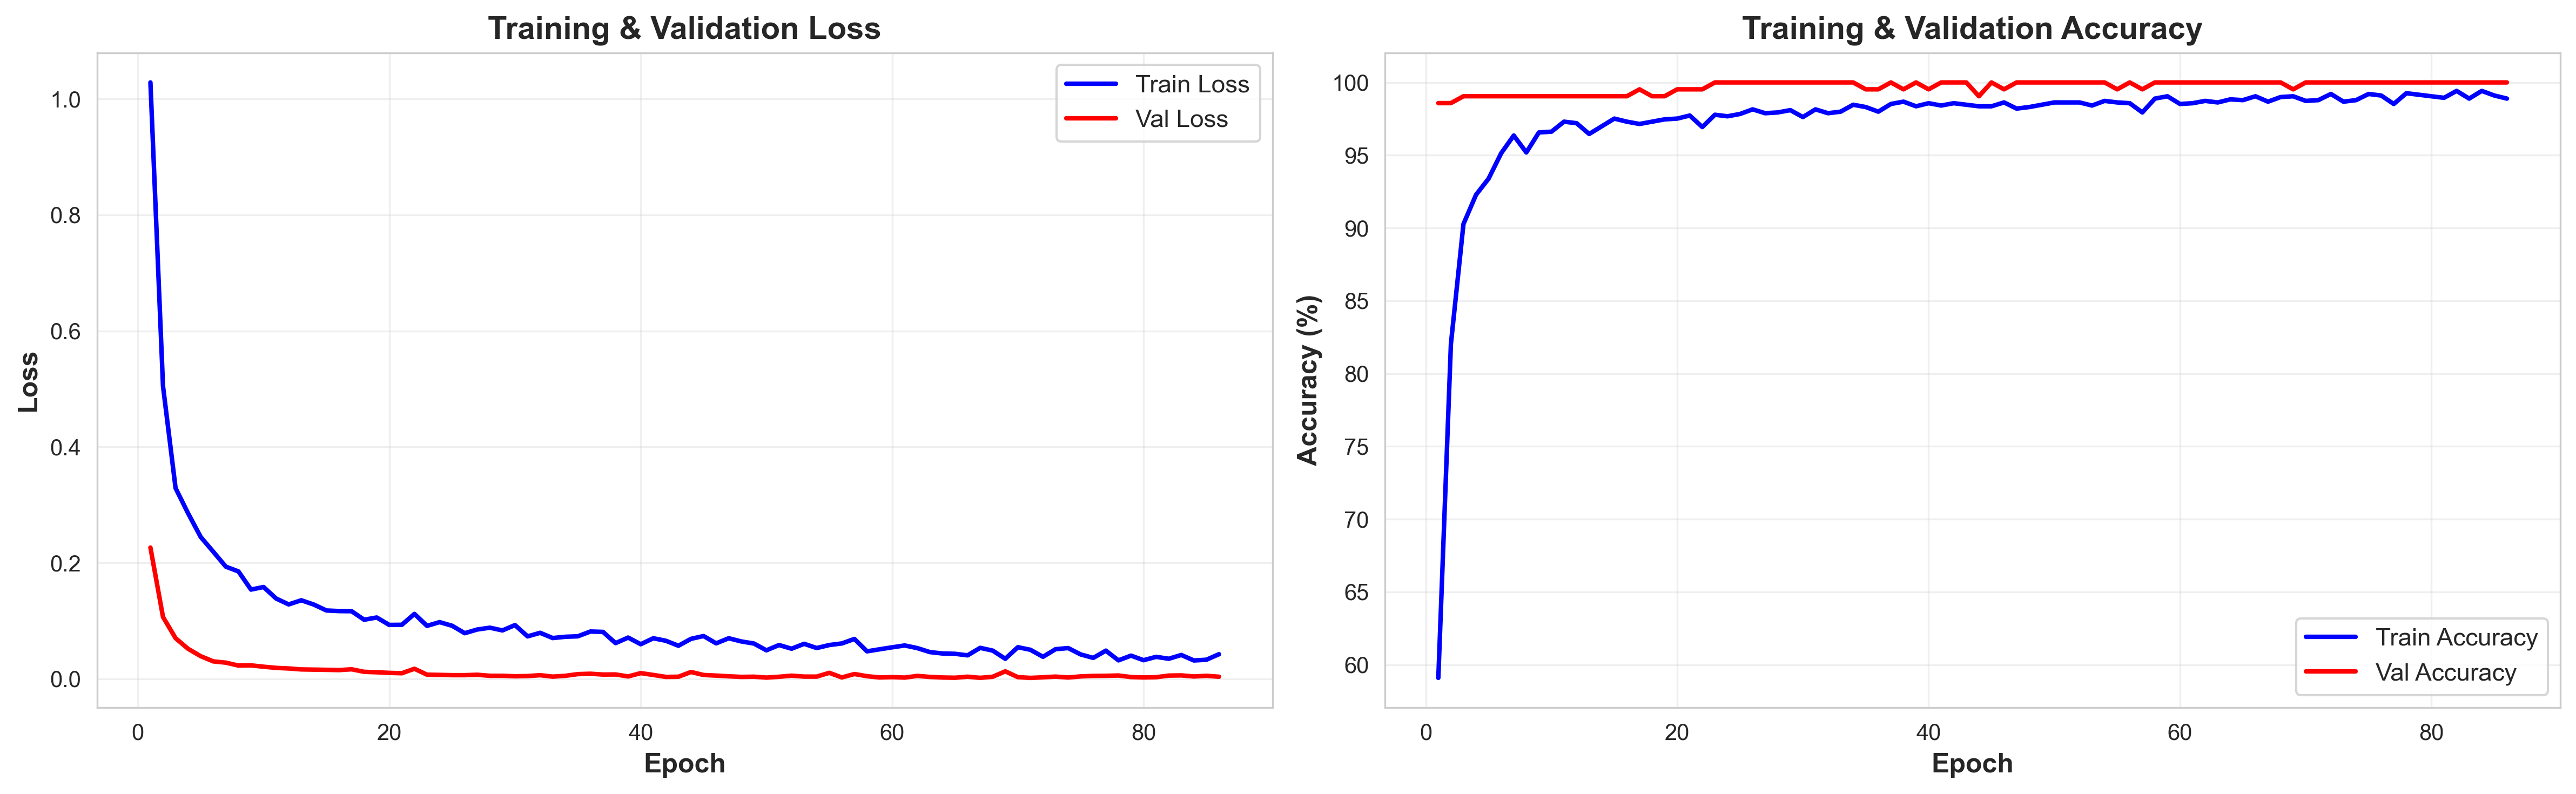


✓ Training history plot saved to: ../results/plots/cnn_training_history.png

Training Summary:
  Total epochs: 86
  Final train loss: 0.0425
  Final train acc: 98.89%
  Best val loss: 0.0016 (epoch 71)
  Best val acc: 100.00% (epoch 23)


In [12]:
# Plot training history for final model
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Get number of epochs
epochs_range = range(1, len(history_final['train_loss']) + 1)

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs_range, history_final['train_loss'], 'b-', linewidth=2, markersize=4, label='Train Loss')
ax1.plot(epochs_range, history_final['val_loss'], 'r-', linewidth=2, markersize=4, label='Val Loss')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: Accuracy curves
ax2 = axes[1]
ax2.plot(epochs_range, history_final['train_acc'], 'b-', linewidth=2, markersize=4, label='Train Accuracy')
ax2.plot(epochs_range, history_final['val_acc'], 'r-', linewidth=2, markersize=4, label='Val Accuracy')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/cnn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Training history plot saved to: ../results/plots/cnn_training_history.png")
print(f"\nTraining Summary:")
print(f"  Total epochs: {len(epochs_range)}")
print(f"  Final train loss: {history_final['train_loss'][-1]:.4f}")
print(f"  Final train acc: {history_final['train_acc'][-1]:.2f}%")
print(f"  Best val loss: {min(history_final['val_loss']):.4f} (epoch {np.argmin(history_final['val_loss']) + 1})")
print(f"  Best val acc: {max(history_final['val_acc']):.2f}% (epoch {np.argmax(history_final['val_acc']) + 1})")

## 8️⃣ Evaluate FINAL Model on Fixed Test Set

**ĐÂY LÀ ĐÁNH GIÁ CUỐI CÙNG:**
- Dùng mô hình cuối (trained on 80%)
- Đánh giá trên 20% fixed test set (chưa từng thấy)
- Đây là metrics để báo cáo

In [13]:
print("="*70)
print("STEP 4: EVALUATE FINAL MODEL ON FIXED TEST SET")
print("="*70)

print(f"\nEvaluating on fixed test set ({len(X_test_fixed)} samples)...")

test_metrics = trainer_final.evaluate(X_test_fixed, y_test_fixed, batch_size=CONFIG['batch_size'])

print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE ON FIXED TEST SET")
print("="*70)
print(f"Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"Precision: {test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)")
print(f"Recall:    {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"F1-Score:  {test_metrics['f1_score']:.4f} ({test_metrics['f1_score']*100:.2f}%)")
print(f"ROC-AUC:   {test_metrics['roc_auc']:.4f} ({test_metrics['roc_auc']*100:.2f}%)")
print("="*70)

print("\n✅ This is the FINAL performance to report!")
print("   Model: Trained on 80% train+val")
print("   Evaluated on: 20% fixed test set (never seen before)")

2025-11-20 13:33:56 - models.cnn.trainer - INFO - 
2025-11-20 13:33:56 - models.cnn.trainer - INFO - EVALUATING ON TEST SET
2025-11-20 13:33:56 - models.cnn.trainer - INFO - ======================================================================
2025-11-20 13:33:56 - models.cnn.trainer - INFO - 
Test Set Metrics:
2025-11-20 13:33:56 - models.cnn.trainer - INFO -   Accuracy:  0.9924 (99.24%)
2025-11-20 13:33:56 - models.cnn.trainer - INFO -   Precision: 0.9924 (99.24%)
2025-11-20 13:33:56 - models.cnn.trainer - INFO -   Recall:    0.9924 (99.24%)
2025-11-20 13:33:56 - models.cnn.trainer - INFO -   F1-Score:  0.9924 (99.24%)
2025-11-20 13:33:56 - models.cnn.trainer - INFO -   ROC-AUC:   0.9998 (99.98%)
2025-11-20 13:33:56 - models.cnn.trainer - INFO - ======================================================================



STEP 4: EVALUATE FINAL MODEL ON FIXED TEST SET

Evaluating on fixed test set (526 samples)...

FINAL MODEL PERFORMANCE ON FIXED TEST SET
Accuracy:  0.9924 (99.24%)
Precision: 0.9924 (99.24%)
Recall:    0.9924 (99.24%)
F1-Score:  0.9924 (99.24%)
ROC-AUC:   0.9998 (99.98%)

✅ This is the FINAL performance to report!
   Model: Trained on 80% train+val
   Evaluated on: 20% fixed test set (never seen before)


### Confusion Matrix (Fixed Test Set)

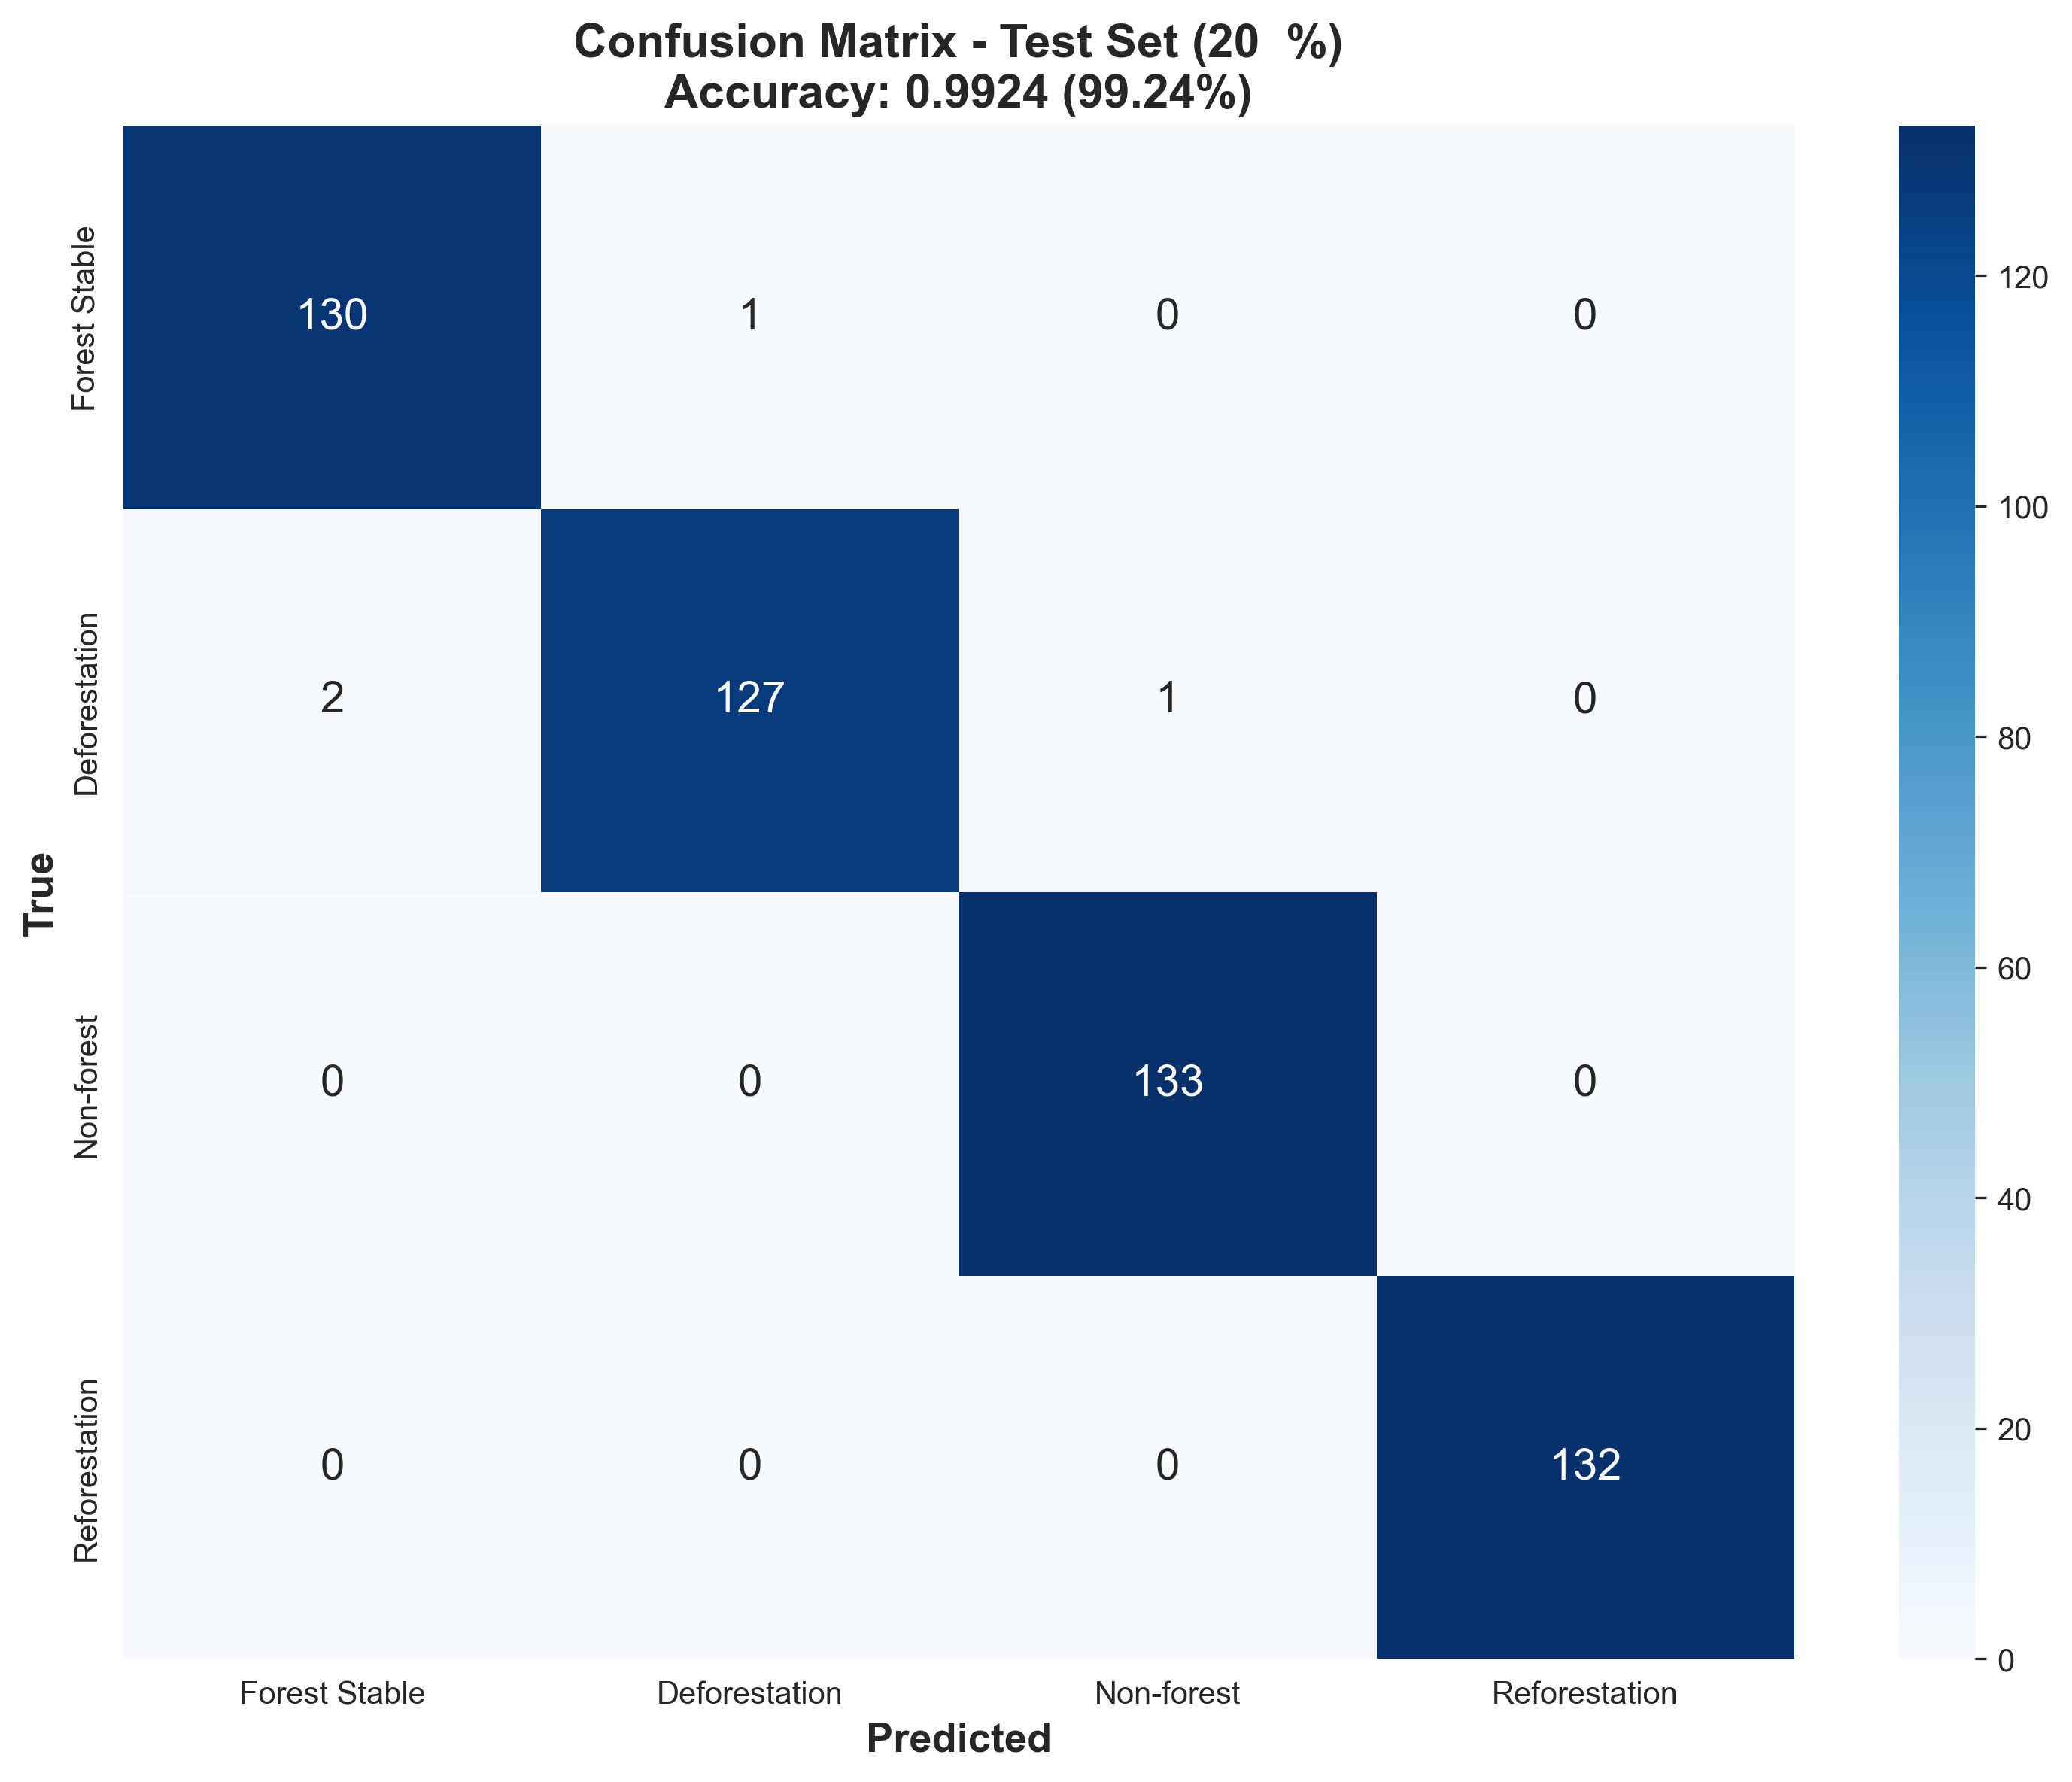


Classification Report (Fixed Test Set):
               precision    recall  f1-score   support

Forest Stable       0.98      0.99      0.99       131
Deforestation       0.99      0.98      0.98       130
   Non-forest       0.99      1.00      1.00       133
Reforestation       1.00      1.00      1.00       132

     accuracy                           0.99       526
    macro avg       0.99      0.99      0.99       526
 weighted avg       0.99      0.99      0.99       526



In [14]:
# Compute confusion matrix for fixed test set
cm_test = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])

# Class names for 4 classes
class_names = ['Forest Stable', 'Deforestation', 'Non-forest', 'Reforestation']

# Plot confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={'size': 14})
ax.set_xlabel('Predicted', fontsize=13, fontweight='bold')
ax.set_ylabel('True', fontsize=13, fontweight='bold')
ax.set_title(f'Confusion Matrix - Test Set (20  %)\nAccuracy: {test_metrics["accuracy"]:.4f} ({test_metrics["accuracy"]*100:.2f}%)',
                 fontsize=15, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/plots/cnn_confusion_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report (Fixed Test Set):")
print("="*70)
print(classification_report(test_metrics['labels'], test_metrics['predictions'],
                          target_names=class_names))

### ROC Curve

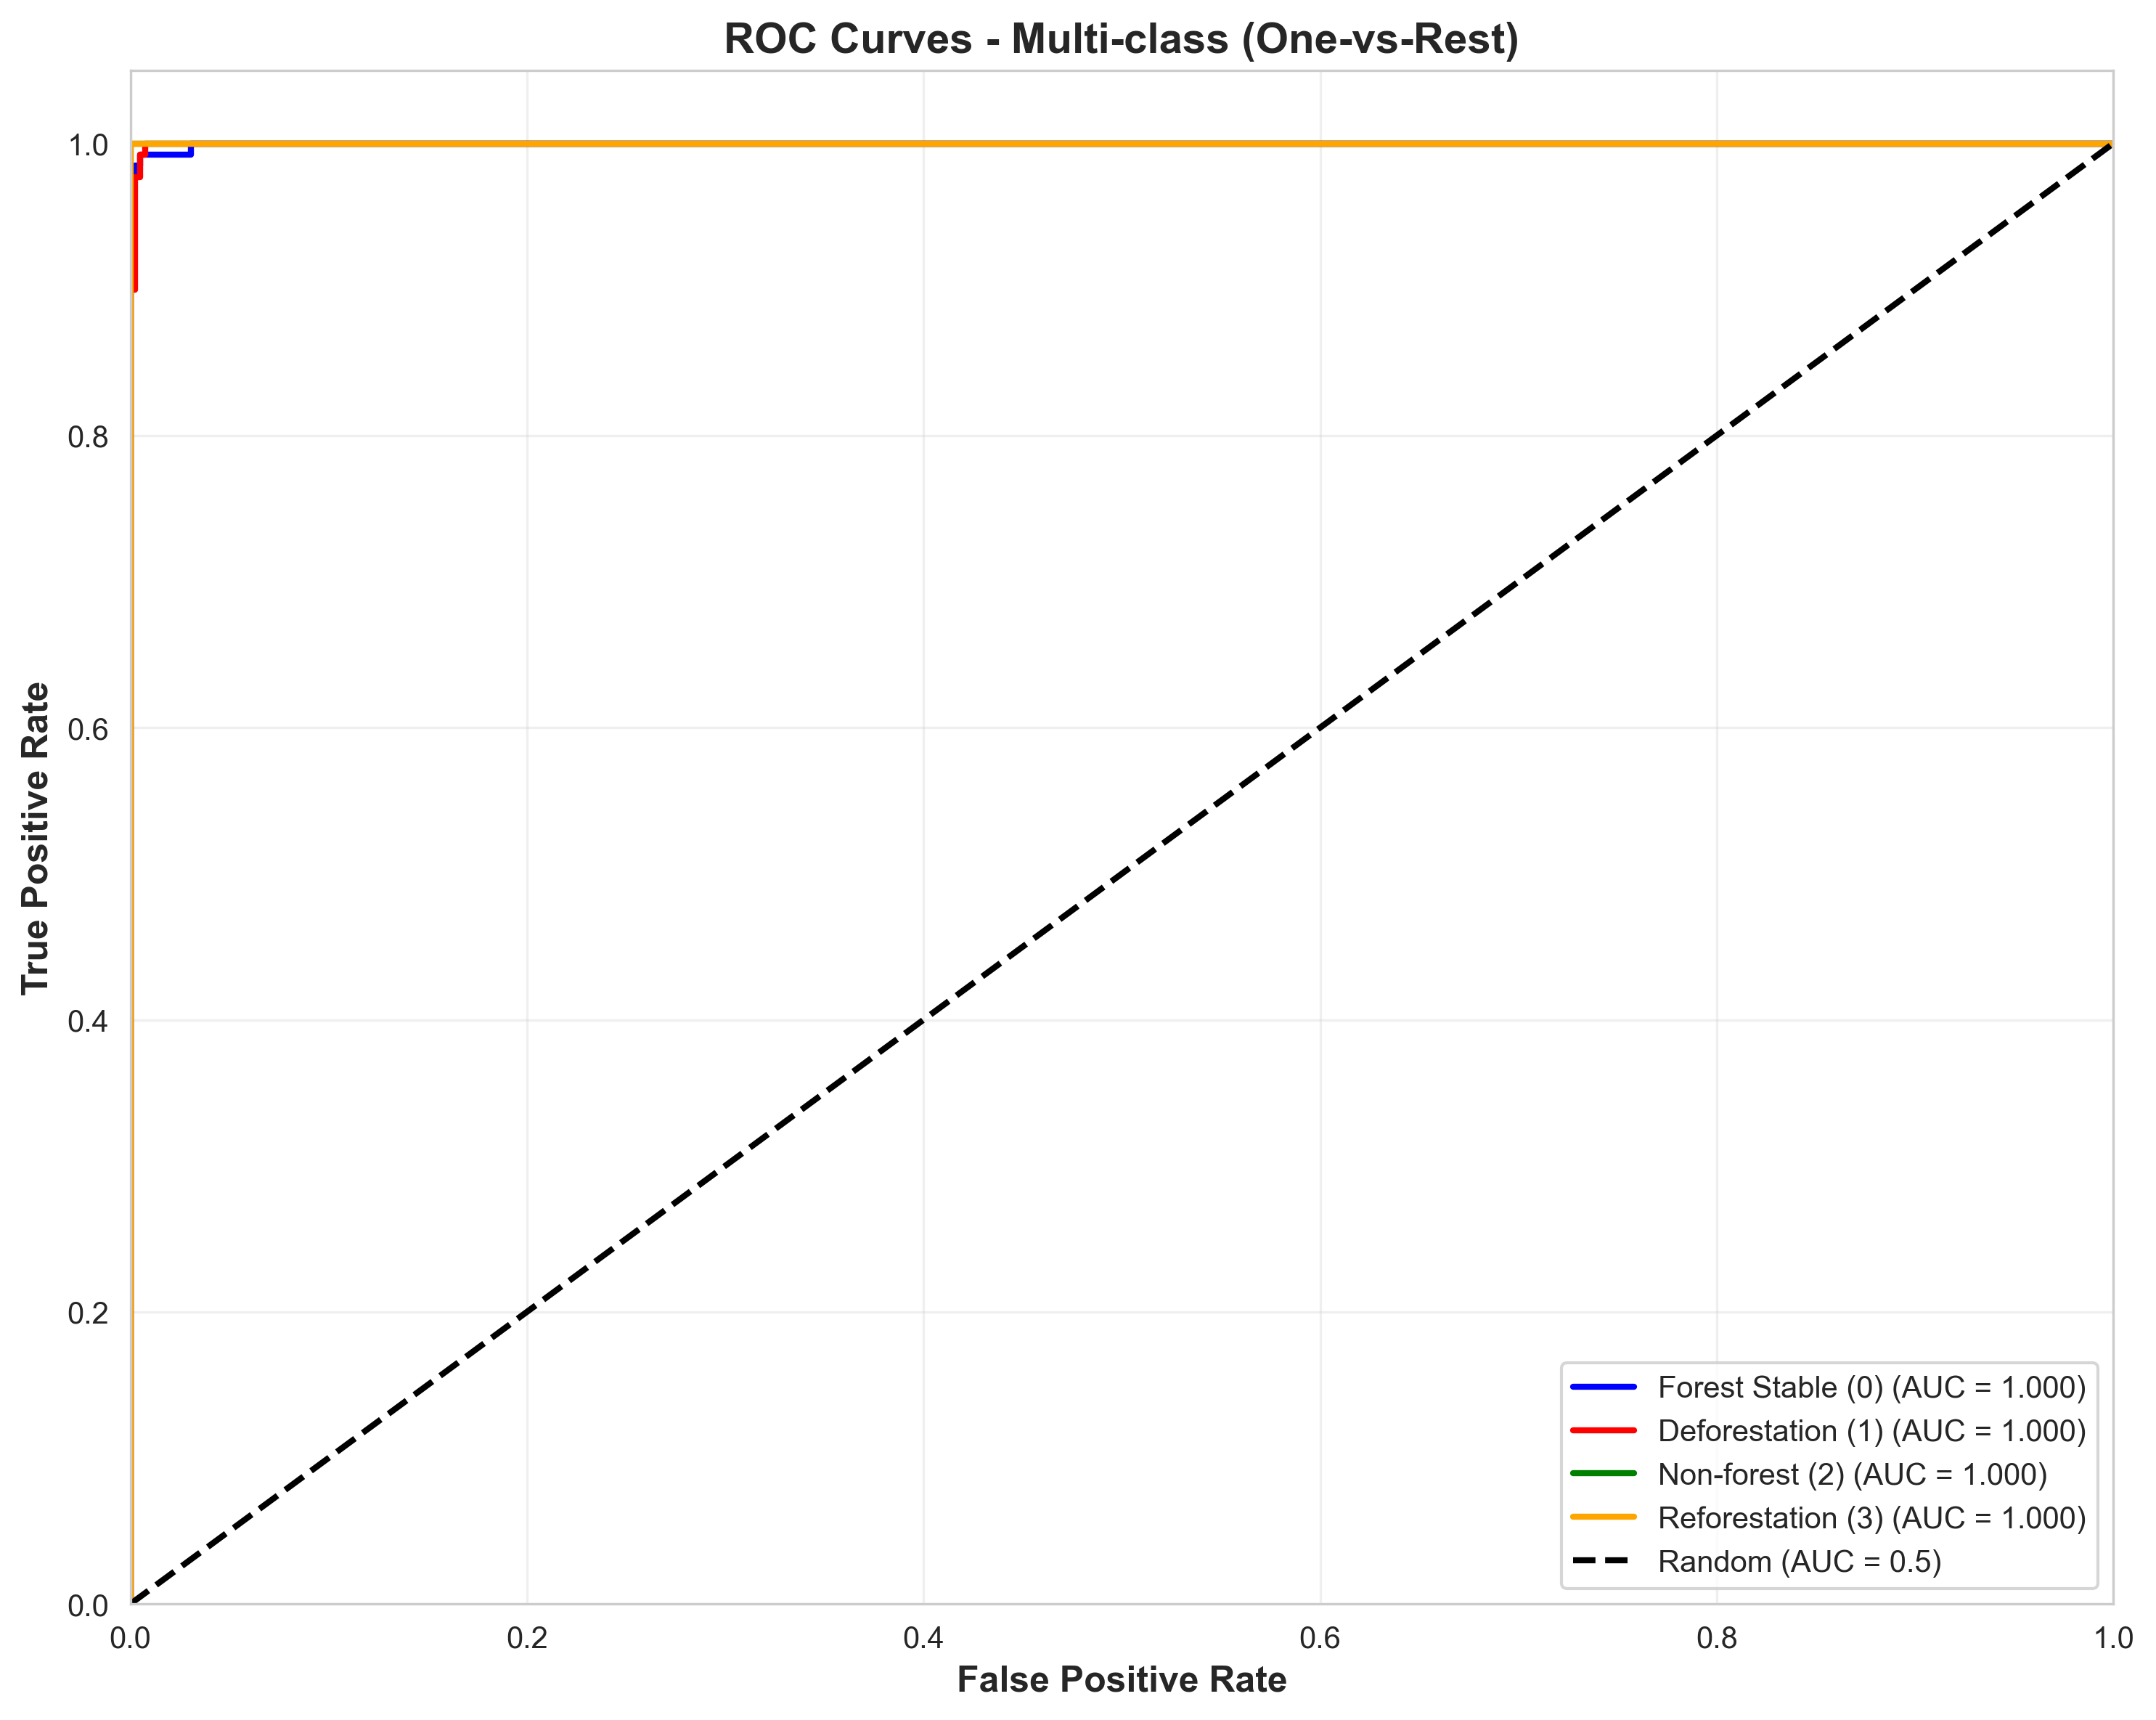


ROC-AUC Scores:
  Class 0 (Forest Stable): 0.9997
  Class 1 (Deforestation): 0.9997
  Class 2 (Non-forest): 1.0000
  Class 3 (Reforestation): 1.0000
  Average: 0.9998


In [15]:
# ROC Curve for Multi-class (One-vs-Rest)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

n_classes = 4
y_test_bin = label_binarize(test_metrics['labels'], classes=[0, 1, 2, 3])
y_score = test_metrics['probabilities']

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['blue', 'red', 'green', 'orange'])
class_names = ['Forest Stable (0)', 'Deforestation (1)', 'Non-forest (2)', 'Reforestation (3)']

for i, color, name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{name} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Multi-class (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../results/plots/cnn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nROC-AUC Scores:")
print(f"  Class 0 (Forest Stable): {roc_auc[0]:.4f}")
print(f"  Class 1 (Deforestation): {roc_auc[1]:.4f}")
print(f"  Class 2 (Non-forest): {roc_auc[2]:.4f}")
print(f"  Class 3 (Reforestation): {roc_auc[3]:.4f}")
print(f"  Average: {np.mean(list(roc_auc.values())):.4f}")

## 9️⃣ Predict Full Raster

**Note:** This step may take 10-15 minutes

In [16]:
from models.cnn.predictor import RasterPredictor

print("Creating raster predictor...")
predictor = RasterPredictor(
    model=model_final,  # Use FINAL model
    device=CONFIG['device'],
    patch_size=CONFIG['patch_size'],
    batch_size=CONFIG['pred_batch_size']
)

print("\nPredicting full raster using FINAL model...")
print("(This may take 10-15 minutes)\n")

prediction_start = time.time()

# Use same normalization as training
multiclass_map = predictor.predict_raster(
    feature_stack,
    valid_mask,
    stride=CONFIG['pred_stride'],
    normalize=True,
    normalization_stats=normalization_stats
)

prediction_time = time.time() - prediction_start
print(f"\n✓ Prediction completed in {prediction_time/60:.2f} minutes")

2025-11-20 13:33:59 - models.cnn.predictor - INFO - RasterPredictor initialized on device: cuda
2025-11-20 13:33:59 - models.cnn.predictor - INFO - 
2025-11-20 13:33:59 - models.cnn.predictor - INFO - PREDICTING FULL RASTER WITH CNN
2025-11-20 13:33:59 - models.cnn.predictor - INFO - ======================================================================
2025-11-20 13:33:59 - models.cnn.predictor - INFO - Raster shape: 10917 x 12547
2025-11-20 13:33:59 - models.cnn.predictor - INFO - Patch size: 3x3
2025-11-20 13:33:59 - models.cnn.predictor - INFO - Stride: 1
2025-11-20 13:33:59 - models.cnn.predictor - INFO - Batch size: 8000
2025-11-20 13:33:59 - models.cnn.predictor - INFO - Temperature: 1.0 (normal)
2025-11-20 13:33:59 - models.cnn.predictor - INFO - 
Extracting patches...
2025-11-20 13:33:59 - models.cnn.patch_extractor - INFO - 
Extracting patches for full raster prediction...
2025-11-20 13:33:59 - models.cnn.patch_extractor - INFO - Raster shape: 10917 x 12547
2025-11-20 13:33:5

Creating raster predictor...

Predicting full raster using FINAL model...
(This may take 10-15 minutes)



2025-11-20 13:34:00 - models.cnn.patch_extractor - INFO - Total potential patches: 136,928,675
2025-11-20 13:34:01 - models.cnn.patch_extractor - INFO - After center mask filter: 16,246,923
2025-11-20 13:34:01 - models.cnn.patch_extractor - INFO - Processing 325 chunks of 50,000 patches...
2025-11-20 13:34:22 - models.cnn.patch_extractor - INFO -   Processed 10/325 chunks...
2025-11-20 13:34:42 - models.cnn.patch_extractor - INFO -   Processed 20/325 chunks...
2025-11-20 13:35:03 - models.cnn.patch_extractor - INFO -   Processed 30/325 chunks...
2025-11-20 13:35:24 - models.cnn.patch_extractor - INFO -   Processed 40/325 chunks...
2025-11-20 13:35:45 - models.cnn.patch_extractor - INFO -   Processed 50/325 chunks...
2025-11-20 13:36:06 - models.cnn.patch_extractor - INFO -   Processed 60/325 chunks...
2025-11-20 13:36:27 - models.cnn.patch_extractor - INFO -   Processed 70/325 chunks...
2025-11-20 13:36:48 - models.cnn.patch_extractor - INFO -   Processed 80/325 chunks...
2025-11-20 13


✓ Prediction completed in 14.49 minutes


### Save Results

In [17]:
# Save rasters
print("Saving results...")

output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)
(output_dir / 'rasters').mkdir(exist_ok=True)
(output_dir / 'models').mkdir(exist_ok=True)
(output_dir / 'data').mkdir(exist_ok=True)
(output_dir / 'plots').mkdir(exist_ok=True)

# Save multiclass raster only
predictor.save_rasters(
    metadata['s2_before'],
    multiclass_path=output_dir / 'rasters' / 'cnn_multiclass_final.tif'
)

# Save FINAL model
trainer_final.save_model(output_dir / 'models' / 'cnn_final_model.pth')

# Compute confusion matrix for saving
cm_test = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])

# Save comprehensive metrics
metrics_to_save = {
    'workflow': {
        'description': 'Fixed test set (15%) + 5-fold CV + Final model training',
        'step1': 'Split 15% fixed test set',
        'step2': '5-fold CV on 85% train+val',
        'step3': 'Train final model on full 85%',
        'step4': 'Evaluate final model on 15% test'
    },
    'cv_results': {
        'n_folds': 5,
        'fold_results': fold_results,
        'mean_val_acc': float(np.mean([r['val_acc'] for r in fold_results])),
        'std_val_acc': float(np.std([r['val_acc'] for r in fold_results])),
        'mean_val_f1': float(np.mean([r['val_f1'] for r in fold_results])),
        'std_val_f1': float(np.std([r['val_f1'] for r in fold_results]))
    },
    'final_test': {
        'accuracy': float(test_metrics['accuracy']),
        'precision': float(test_metrics['precision']),
        'recall': float(test_metrics['recall']),
        'f1_score': float(test_metrics['f1_score']),
        'roc_auc': float(test_metrics['roc_auc']),
        'confusion_matrix': cm_test.tolist()
    },
    'data_split': {
        'total_samples': len(ground_truth),
        'trainval_samples': len(trainval_indices),
        'test_samples': len(test_indices_fixed),
        'trainval_percent': len(trainval_indices)/len(ground_truth)*100,
        'test_percent': len(test_indices_fixed)/len(ground_truth)*100
    },
    'execution_times': {
        'cv_seconds': float(cv_total_time),
        'cv_minutes': float(cv_total_time / 60),
        'training_seconds': float(training_time),
        'training_minutes': float(training_time / 60),
        'prediction_seconds': float(prediction_time),
        'prediction_minutes': float(prediction_time / 60),
        'total_minutes': float((cv_total_time + training_time + prediction_time) / 60)
    },
    'model_config': CONFIG
}

with open(output_dir / 'data' / 'cnn_final_metrics.json', 'w') as f:
    json.dump(metrics_to_save, f, indent=2)

# Save training history
with open(output_dir / 'data' / 'cnn_final_training_history.json', 'w') as f:
    json.dump(history_final, f, indent=2)

# Save CV results separately
with open(output_dir / 'data' / 'cnn_cv_results.json', 'w') as f:
    json.dump({'fold_results': fold_results}, f, indent=2)

print("\n✓ All results saved successfully!")
print("\n📁 Saved files:")
print("  - cnn_multiclass_final.tif (4-class raster)")
print("  - cnn_final_model.pth (model)")
print("  - cnn_final_metrics.json (all metrics)")
print("  - cnn_final_training_history.json")
print("  - cnn_cv_results.json (5-fold CV results)")

2025-11-20 13:48:29 - models.cnn.predictor - INFO - 
Saving output rasters...


Saving results...


2025-11-20 13:48:30 - models.cnn.predictor - INFO -   Multiclass raster saved: ..\results\rasters\cnn_multiclass_final.tif
2025-11-20 13:48:30 - models.cnn.trainer - INFO - Model saved to: ..\results\models\cnn_final_model.pth



✓ All results saved successfully!

📁 Saved files:
  - cnn_multiclass_final.tif (4-class raster)
  - cnn_final_model.pth (model)
  - cnn_final_metrics.json (all metrics)
  - cnn_final_training_history.json
  - cnn_cv_results.json (5-fold CV results)


## 🔟 Visualization using src.core.visualization

In [18]:
from core.visualization import Visualizer

print("Creating visualizations using src.core.visualization...")

# Initialize Visualizer
visualizer = Visualizer()

# Plot 4-class multiclass map
print("\n1. Plotting 4-class multiclass map...")
visualizer.plot_multiclass_map(
    multiclass_map=multiclass_map,
    valid_mask=valid_mask,
    output_path=output_dir / 'plots' / 'cnn_multiclass_map.png'
)

print("\n✓ Visualization created successfully!")

2025-11-20 13:48:30 - core.visualization - INFO - 
Plotting 4-class multiclass map...


Creating visualizations using src.core.visualization...

1. Plotting 4-class multiclass map...


2025-11-20 13:49:24 - core.visualization - INFO -   ✓ Saved to: ..\results\plots\cnn_multiclass_map.png



✓ Visualization created successfully!


### Classification Statistics

In [19]:
print("\n" + "="*70)
print("CLASSIFICATION STATISTICS (4-Class)")
print("="*70)

# Count pixels for each class
class_0_pixels = np.sum(multiclass_map[valid_mask] == 0)  # Forest Stable
class_1_pixels = np.sum(multiclass_map[valid_mask] == 1)  # Deforestation
class_2_pixels = np.sum(multiclass_map[valid_mask] == 2)  # Non-forest
class_3_pixels = np.sum(multiclass_map[valid_mask] == 3)  # Reforestation
total_valid = np.sum(valid_mask)

print(f"\nTotal pixels:")
print(f"  Valid pixels:          {total_valid:,}")
print(f"  Invalid pixels:        {np.sum(~valid_mask):,}")

print(f"\n4-Class breakdown:")
print(f"  Forest Stable (0):     {class_0_pixels:,} ({class_0_pixels/total_valid*100:.2f}%)")
print(f"  Deforestation (1):     {class_1_pixels:,} ({class_1_pixels/total_valid*100:.2f}%)")
print(f"  Non-forest (2):        {class_2_pixels:,} ({class_2_pixels/total_valid*100:.2f}%)")
print(f"  Reforestation (3):     {class_3_pixels:,} ({class_3_pixels/total_valid*100:.2f}%)")

print(f"\nArea estimates (10m resolution):")
print(f"  Forest Stable area:    {class_0_pixels * 100 / 10000:.2f} ha")
print(f"  Deforestation area:    {class_1_pixels * 100 / 10000:.2f} ha")
print(f"  Non-forest area:       {class_2_pixels * 100 / 10000:.2f} ha")
print(f"  Reforestation area:    {class_3_pixels * 100 / 10000:.2f} ha")
print(f"  Total valid area:      {total_valid * 100 / 10000:.2f} ha")

print("="*70)


CLASSIFICATION STATISTICS (4-Class)

Total pixels:
  Valid pixels:          16,246,925
  Invalid pixels:        120,728,674

4-Class breakdown:
  Forest Stable (0):     12,232,096 (75.29%)
  Deforestation (1):     1,504,809 (9.26%)
  Non-forest (2):        1,819,204 (11.20%)
  Reforestation (3):     690,816 (4.25%)

Area estimates (10m resolution):
  Forest Stable area:    122320.96 ha
  Deforestation area:    15048.09 ha
  Non-forest area:       18192.04 ha
  Reforestation area:    6908.16 ha
  Total valid area:      162469.25 ha


## 📊 Final Summary

In [20]:
print("\n" + "="*70)
print("CNN DEFORESTATION DETECTION - FINAL SUMMARY")
print("="*70)

print("\n🔄 WORKFLOW:")
print("  1. Split 15% fixed test set (~{} samples)".format(len(test_indices_fixed)))
print("  2. 5-fold CV on 85% train+val (~{} samples)".format(len(trainval_indices)))
print("  3. Train final model on full 85%")
print("  4. Evaluate final model on 15% test")

print("\n📊 5-FOLD CV RESULTS (for hyperparameter selection):")
val_accs = [r['val_acc'] for r in fold_results]
val_f1s = [r['val_f1'] for r in fold_results]
print(f"  Validation Accuracy: {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")
print(f"  Validation F1-Score: {np.mean(val_f1s):.4f} ± {np.std(val_f1s):.4f}")

print("\n🎯 FINAL MODEL PERFORMANCE (on fixed test set):")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"  Precision: {test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)")
print(f"  Recall:    {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f} ({test_metrics['f1_score']*100:.2f}%)")
print(f"  ROC-AUC:   {test_metrics['roc_auc']:.4f} ({test_metrics['roc_auc']*100:.2f}%)")

print("\n⏱️  EXECUTION TIMES:")
print(f"  5-Fold CV:  {cv_total_time/60:7.2f} minutes")
print(f"  Training:   {training_time/60:7.2f} minutes")
print(f"  Prediction: {prediction_time/60:7.2f} minutes")
print(f"  Total:      {(cv_total_time + training_time + prediction_time)/60:7.2f} minutes")

print("\n📁 OUTPUT FILES:")
print(f"  Rasters:")
print(f"    - cnn_multiclass_final.tif (4-class map)")
print(f"  Models:")
print(f"    - cnn_final_model.pth")
print(f"  Data:")
print(f"    - cnn_final_metrics.json (CV + final test metrics)")
print(f"    - cnn_final_training_history.json")
print(f"    - cnn_cv_results.json")
print(f"  Plots:")
print(f"    - cnn_confusion_matrix_final.png")
print(f"    - cnn_roc_curve.png")
print(f"    - cnn_multiclass_map.png (4-class visualization)")

print("\n📍 RESULTS LOCATION:")
print(f"  All results saved to: ../results/")

print("\n✅ CNN PIPELINE COMPLETED SUCCESSFULLY!")
print("   ✓ Fixed test set approach (no data leakage)")
print("   ✓ 5-fold CV for hyperparameter validation")
print("   ✓ Final model trained on full train+val")
print("   ✓ Evaluation on truly held-out test set")
print("   ✓ 4-class multiclass map generated")
print("="*70 + "\n")


CNN DEFORESTATION DETECTION - FINAL SUMMARY

🔄 WORKFLOW:
  1. Split 15% fixed test set (~526 samples)
  2. 5-fold CV on 85% train+val (~2104 samples)
  3. Train final model on full 85%
  4. Evaluate final model on 15% test

📊 5-FOLD CV RESULTS (for hyperparameter selection):
  Validation Accuracy: 0.9891 ± 0.0049
  Validation F1-Score: 0.9891 ± 0.0049

🎯 FINAL MODEL PERFORMANCE (on fixed test set):
  Accuracy:  0.9924 (99.24%)
  Precision: 0.9924 (99.24%)
  Recall:    0.9924 (99.24%)
  F1-Score:  0.9924 (99.24%)
  ROC-AUC:   0.9998 (99.98%)

⏱️  EXECUTION TIMES:
  5-Fold CV:     1.66 minutes
  Training:      0.36 minutes
  Prediction:   14.49 minutes
  Total:        16.50 minutes

📁 OUTPUT FILES:
  Rasters:
    - cnn_multiclass_final.tif (4-class map)
  Models:
    - cnn_final_model.pth
  Data:
    - cnn_final_metrics.json (CV + final test metrics)
    - cnn_final_training_history.json
    - cnn_cv_results.json
  Plots:
    - cnn_confusion_matrix_final.png
    - cnn_roc_curve.png
    